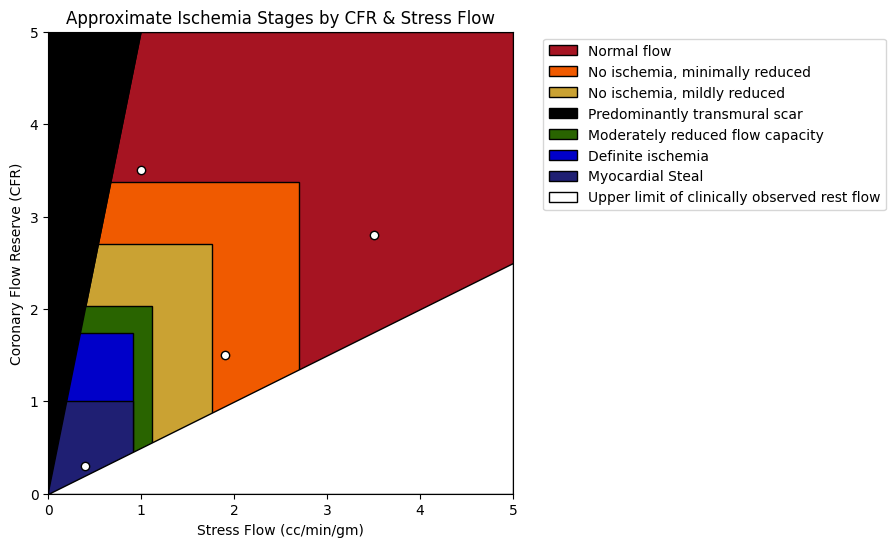

{'CFR': 0.3, 'Stress Flow': 0.4, 'Ischemia stadium': 'Myocardial Steal', 'color': '#1f1f73'}
{'CFR': 1.5, 'Stress Flow': 1.9, 'Ischemia stadium': 'No ischemia, minimally reduced', 'color': '#f05a00'}
{'CFR': 3.5, 'Stress Flow': 1.0, 'Ischemia stadium': 'Undefined', 'color': 'gray'}
{'CFR': 2.8, 'Stress Flow': 3.5, 'Ischemia stadium': 'Undefined', 'color': 'gray'}


In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import matplotlib as mpl

# Cutoffs for the different regions identified from the paper text
# Integrating Noninvasive Absolute Flow, Coronary Flow Reserve, and Ischemic Thresholds Into a
# Comprehensive Map of Physiological Severity, Nils P. Johnson, MD, MS, K. Lance Gould, MD,
# JACC: Cardiovascular Imaging, 2012;5


RED = "#a61422"
ORANGE = "#f05a00"
YELLOW = "#caa233"
GREEN = "#296400"
BLUE = "#0000c9"
PURPLE = "#1f1f73"
BLACK = "#000000"
WHITE="#FFFFFF"

Y_CUTOFF_PURPLE=1
Y_CUTOFF_BLUE=1.74
Y_CUTOFF_GREEN=2.03
Y_CUTOFF_YELLOW=2.7
Y_CUTOFF_ORANGE=3.37

X_CUTOFF_PURPLE = X_CUTOFF_BLUE = 0.91
X_CUTOFF_GREEN=1.12
X_CUTOFF_YELLOW=1.76
X_CUTOFF_ORANGE=2.70




def classify_point(cfr, stress_flow):
    """
    Returns (stage_name, color_hex) for a single (cfr, stress_flow) pair,
    using rough cutoffs chosen from visual inspection.
    Adjust these cutoffs as needed.
    """
    assert cfr >= 0, "CFR must be non-negative"
    assert stress_flow >= 0, "Stress Flow must be non-negative"


    # Black region (predominantly transmural scar): 
    #   approximate rule: very low stress_flow (< 0.5)
    if stress_flow/cfr < 0.2:
        return "Predominantly transmural scar", BLACK  # black
    elif stress_flow/cfr > 2:
        return "Upper limit of clinically observed rest flow", WHITE
    elif cfr<Y_CUTOFF_PURPLE and stress_flow<X_CUTOFF_PURPLE:
        return "Myocardial Steal", PURPLE
    elif cfr<Y_CUTOFF_BLUE and stress_flow<X_CUTOFF_BLUE:
        return "Definite ischemia", BLUE
    elif cfr<Y_CUTOFF_GREEN and stress_flow<X_CUTOFF_GREEN:
        return "Moderately reduced flow capacity", GREEN
    elif cfr<Y_CUTOFF_YELLOW and stress_flow<X_CUTOFF_YELLOW:
        return "No ischemia, mildly reduced", YELLOW
    elif cfr<Y_CUTOFF_ORANGE and stress_flow<X_CUTOFF_ORANGE:
        return "No ischemia, minimally reduced", ORANGE
    elif cfr>=Y_CUTOFF_ORANGE and stress_flow>=X_CUTOFF_ORANGE: 
        return "Normal flow", RED
    else:
        return "Undefined", "gray" 
    
    

    
    


def plot_background_regions(ax, poly_alpha=1):
    """
    Draws approximate colored polygons for each region as seen in the reference plot.
    These are rough approximations of the boundaries you see in the figure.
    """

    

    # For simplicity, we define polygons by hand. Adjust as needed.
    
    red_poly = Polygon([(0,0), (5,0), (5,5), (0,5)], 
                         closed=True, facecolor=RED, alpha=poly_alpha,
                         edgecolor=BLACK, label="Normal flow")

    # Orange region: No ischemia, minimally reduced
    orange_poly = Polygon([(0,0), (X_CUTOFF_ORANGE, 0), (X_CUTOFF_ORANGE,Y_CUTOFF_ORANGE), (0,Y_CUTOFF_ORANGE)], 
                          closed=True, facecolor=ORANGE, alpha=poly_alpha,
                          edgecolor=BLACK, label="No ischemia, minimally reduced")

    # Yellow region: No ischemia, mildly reduced
    yellow_poly = Polygon([(0,0), (X_CUTOFF_YELLOW, 0), (X_CUTOFF_YELLOW, Y_CUTOFF_YELLOW), (0, Y_CUTOFF_YELLOW)], 
                          closed=True, facecolor=YELLOW, alpha=poly_alpha,
                          edgecolor=BLACK, label="No ischemia, mildly reduced")
    
    # Green region: Moderately reduced
    green_poly = Polygon([(0,0), (X_CUTOFF_GREEN, 0), (X_CUTOFF_GREEN, Y_CUTOFF_GREEN), (0, Y_CUTOFF_GREEN)], 
                         closed=True, facecolor=GREEN, alpha=poly_alpha,
                         edgecolor=BLACK, label="Moderately reduced flow capacity")
    
    # Blue region: Definite ischemia
    blue_poly = Polygon([(0,0), (X_CUTOFF_BLUE, 0), (X_CUTOFF_BLUE, Y_CUTOFF_BLUE), (0, Y_CUTOFF_BLUE)], 
                        closed=True, facecolor=BLUE, alpha=poly_alpha,
                        edgecolor=BLACK, label="Definite ischemia")

    # Purple region: Myocardial Steal
    purple_poly = Polygon([(0,0), (X_CUTOFF_PURPLE, 0), (X_CUTOFF_PURPLE, Y_CUTOFF_PURPLE), (0, Y_CUTOFF_PURPLE)], 
                          closed=True, facecolor=PURPLE, alpha=poly_alpha,
                          edgecolor=BLACK, label="Myocardial Steal")

    white_poly = Polygon([(0,0), (5,0), (5,2.5)], 
                         closed=True, facecolor=WHITE, alpha=poly_alpha, 
                         edgecolor=BLACK, label="Upper limit of clinically observed rest flow")
    
    black_poly = Polygon([(0,0),  (1,5), (0,5)], 
                         closed=True, facecolor=BLACK, alpha=poly_alpha, 
                         edgecolor=BLACK, label="Predominantly transmural scar")

    # Add them to the axes
    for poly in [red_poly,orange_poly, yellow_poly,black_poly, green_poly,
                 blue_poly, purple_poly,black_poly, white_poly]:
        ax.add_patch(poly)

    # We can manually set up the legend by grabbing the handles/labels we just added
    # but to keep them in a nice order, collect them:
    handles, labels = ax.get_legend_handles_labels()
    # Deduplicate, keeping order:
    unique = list(dict(zip(labels, handles)).items())
    ax.legend([h for _,h in unique], [l for l,_ in unique], bbox_to_anchor=(1.05, 1), loc='upper left')


def create_cfr_stressflow_plot(
        points, 
        save_path=None, 
        file_format='png', 
        show_plot=True,
        poly_alpha=1
    ):
    """
    Plots the CFR–StressFlow colored background approximating your figure,
    overlays `points` as white scatter, and returns a list of result dicts.
    
    Parameters
    ----------
    points : list of (CFR, StressFlow) or a single (CFR, StressFlow)
    save_path : optional path (without extension) for saving the figure
    file_format : file format for saving (e.g. 'png', 'pdf')
    show_plot : if False, the plot is not displayed (useful for batch runs)
    
    Returns
    -------
    A list of dictionaries of the form
      [
        {
         "CFR": <float>,
         "Stress Flow": <float>,
         "Ischemia stadium": <string>,
         "color": <hex or named color>
        }, ...
      ]
    or a single dict if only one input pair was given.
    """
    # Accept a single pair or a list of pairs
    if isinstance(points, tuple) and len(points) == 2:
        points = [points]

    results = []
    
    # Classify each point
    for (cfr, sf) in points:
        stage, color_hex = classify_point(cfr, sf)
        results.append({
            "CFR": cfr,
            "Stress Flow": sf,
            "Ischemia stadium": stage,
            "color": color_hex
        })

    # If the user wants to skip plot generation, just return
    if not show_plot and save_path is None:
        return results if len(results) > 1 else results[0]
    
    # Create the figure/axes
    fig, ax = plt.subplots(figsize=(6,6))
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)
    ax.set_xlabel("Stress Flow (cc/min/gm)")
    ax.set_ylabel("Coronary Flow Reserve (CFR)")
    ax.set_title("Approximate Ischemia Stages by CFR & Stress Flow")

    # Draw colored background polygons
    plot_background_regions(ax,poly_alpha=poly_alpha)

    # Overlay user points in white
    xvals = [p["Stress Flow"] for p in results]
    yvals = [p["CFR"] for p in results]
    ax.scatter(xvals, yvals, color="white", edgecolor="black", zorder=5)

    # Optionally save figure
    if save_path is not None:
        plt.savefig(f"{save_path}.{file_format}", format=file_format, dpi=150)
    
    # Optionally show figure
    if show_plot:
        plt.show()
    else:
        plt.close(fig)
    
    # Return single dict if only one item, else list
    return results if len(results) > 1 else results[0]

# --------------------------
# Example usage:
if __name__ == "__main__":
    sample_points = [(0.3, 0.4), (1.5, 1.9), (3.5, 1.0), (2.8, 3.5)]
    output = create_cfr_stressflow_plot(
        sample_points, 
        save_path="my_flow_plot", 
        file_format="png", 
        show_plot=True
    )
    for d in output:
        print(d)
